In [36]:
import os
import numpy as np
import pandas as pd
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.widgets as sw
print(si.__version__)
from statsmodels.stats.multitest import multipletests

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from aind_ephys_utils import align, sort
from open_ephys.analysis import Session

import plot_units
import package_unit_data
from pathlib import Path


import analysis_funcs as af
import plotting_funcs as pf

import ast
import pandas as pd

print('Finished loading packages')


0.99.1
Finished loading packages


In [2]:
%matplotlib inline

In [3]:
# flags for use
fig_format = 'png'
annotate_points = False
max_channel = 351
print('max_channel: ', max_channel)
red_tag = 'DRN'
blue_tag = 'x'
OLD = False
chrmine = True

PLOT_GOOD_UNITS = 0
PLOT_ALL_LASER_RESPONSIVE = 1


max_channel:  351


In [4]:
# get the attached data
data_dir = "../data/"
session_id_to_find = "698691_2023-12-26_13-34-25"

for root, dirs, files in os.walk(data_dir):
    for dir in dirs:
        if session_id_to_find in dir:
            session_folder = os.path.join(root, dir)
            # print(session_folder)
            if session_folder.endswith(session_id_to_find):
                raw_session_folder = session_folder
                print('raw session folder: ', session_folder)
            if "sorted" in dir and "spike" not in dir:
               sorting_folder = os.path.join(root, dir)
               print('sorting folder: ', sorting_folder)  
            if "laser_response_metrics" in dir:
               laser_response_metrics_folder = os.path.join(root, dir)
               print('laser response metrics folder: ', laser_response_metrics_folder)  

for root, dirs, files in os.walk(raw_session_folder):
    for file in files:
        if file.endswith("opto.csv"):
            events_file = file
            print(f"Opto file: '{events_file}'")
        if root.endswith("behavior") or root.startswith("Videos") and file.startswith("running_wheel"):
            running_wheel_file = os.path.join(root, file)

laser_response_metrics_files = []
for root, dirs, files in os.walk(laser_response_metrics_folder):
    for file in files:
        if root.endswith("laser_response_metrics") and file.endswith(".csv"):
            laser_response_metrics_files.append(os.path.join(root, file))
            print(f"laser response metrics file: '{file}'")

laser response metrics folder:  ../data/698691_2023-12-26_13-34-25_laser_response_metrics
raw session folder:  ../data/ecephys_698691_2023-12-26_13-34-25
sorting folder:  ../data/ecephys_698691_2023-12-26_13-34-25_sorted_2023-12-27_00-42-28
Opto file: '231226134434_689691.opto.csv'
laser response metrics file: '698691_2023-12-26_13-34-25_ProbeA-AP_laser_response_metrics.csv'


In [58]:
session = laser_response_metrics_files[0][len(data_dir):len(data_dir)+26]
print('session: ', session)
recording_asset = Path(f"../data/ecephys_{session}")
print(recording_asset)
recording_clipped_folder = recording_asset / "ecephys_clipped"
recording_data = Session(recording_clipped_folder).recordnodes[0].recordings[0]


session:  698691_2023-12-26_13-34-25
..\data\ecephys_698691_2023-12-26_13-34-25


In [64]:
# Loading event data
events = recording_data.events
num_streams = len(recording_data.continuous)
print('Num streams: ', num_streams)

laser_pulses = events[(events.processor_id == 103) & (events.line == 2) & (events.state == 1)]
laser_onset_times = laser_pulses['timestamp'].values
print(f"event number {len(laser_onset_times)}")

timestamps = recording_data.continuous[0].timestamps
# Opto stim 
event_ids = pd.read_csv(recording_clipped_folder / f'{events_file}', index_col=0)
powers = np.unique(event_ids['power'].values)
sites = np.unique(event_ids['site'].values)
intervals = event_ids['interval'].values
num_pulses = np.unique(event_ids.num_pulses)[0] # Number of Opto stim pulses
duration = np.unique(event_ids.duration)[0]
pulse_interval = np.unique(event_ids.pulse_interval)[0]
pulse_offset = (duration + pulse_interval)/1000
total_duration = (duration + pulse_interval)*num_pulses

print(f"Laser sites {sites}")
print(f"Laser powers {powers}")
print(f"Num pulses {num_pulses}")
print(f"Duration {duration} ms")
print(f"Offset {pulse_offset} s")


Num streams:  3
event number 280
Laser sites [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Laser powers [0.1]
Num pulses 5
Duration 10 ms
Offset 0.2 s


### Find Good units

In [6]:
for probe_laser_response_file in laser_response_metrics_files:
    print(probe_laser_response_file)
    probe = probe_laser_response_file[-36:-30]        
    quality_metrics_file = Path(f"{sorting_folder}/postprocessed/experiment1_Record Node 104#Neuropix-PXI-100.{probe}-AP_recording1/quality_metrics/metrics.csv")           
    sorting_asset = Path(f"{sorting_folder}/sorting_precurated/experiment1_Record Node 104#Neuropix-PXI-100.{probe}-AP_recording1")
    print('sorting asset: ', sorting_asset)
    waveform_folder = Path(f"{sorting_folder}/postprocessed/experiment1_Record Node 104#Neuropix-PXI-100.{probe}-AP_recording1")           
    sorting_output = si.load_extractor(sorting_asset)    
    we = si.WaveformExtractor.load_from_folder(waveform_folder, with_recording=False, sorting=sorting_output)

    # get timestamps for appropriate probe
    for ind in range(num_streams):
        if f"{probe}-AP"==recording_data.continuous[ind].metadata['stream_name']:
            timestamps = recording_data.continuous[ind].timestamps
   
    laser_response_metrics = pd.read_csv(probe_laser_response_file, index_col=0)
    quality_metrics = pd.read_csv(quality_metrics_file, index_col=0)
    param_group = laser_response_metrics.columns[2][laser_response_metrics.columns[2].find('train'):laser_response_metrics.columns[2].find('all')-1]
    trial_type = laser_response_metrics.columns[2][0:laser_response_metrics.columns[2].find('train')-1]
    
    if PLOT_GOOD_UNITS:
        not_noise_units = laser_response_metrics.query('noise_label == "good"')
        # not_noise_units = laser_response_metrics.query('noise_label == "good" and peak_channel < @max_channel')
        print('Number of not_noise_units: ', len(not_noise_units))

        #units_pass_qc = sorting_output.unit_ids[sorting_output.get_property("pass_qc")]
        units_pass_qc = quality_metrics.query("isi_violations_ratio < 0.5 and amplitude_cutoff < 0.1 and presence_ratio > 0.8")
        print('Number of units_pass_qc: ', len(units_pass_qc))

        units_to_keep = list(set(units_pass_qc.index.tolist()) & set(not_noise_units.unit_id.tolist())) # pass qc and not noisy waveforms
        # units_to_keep = list(set(not_noise_units.unit_id.tolist())) # pass qc and not noisy waveforms
        
        sorting_good = sorting_output.select_units(units_to_keep)
        good_cells = laser_response_metrics.query('unit_id == @units_to_keep')
        interesting_units = good_cells.query(f'{trial_type}_{param_group}_num_sig_pulses_paired > 0.4*{num_pulses}')

        # # if want to manually select units to plot
        # units_to_plot = [28]
        # good_cells = laser_response_metrics.query('unit_id == @units_to_plot')
        # interesting_units = good_cells

        # amplitudes, firing_rates, tagged_unit_blue, tagged_unit_red = package_unit_data.package_unit_data(good_cells, sorting_good, timestamps, laser_onset_times, event_ids, we, session, probe, red_tag, blue_tag, damn_chrmine=chrmine)
        # plot_units.plot_opto_stat_summaries(amplitudes, firing_rates, tagged_unit_blue, tagged_unit_red, good_cells, session, probe, fig_format)
        # if len(good_cells)>0:
            # plot_units.plot_all_good_units(good_cells, sorting_good, timestamps, laser_onset_times, event_ids, we, session, probe, max_channel, param_group, fig_format=fig_format, old_tag=OLD)
        # if len(interesting_units) > 0:
            # plot_units.plot_laser_responsive_units(interesting_units, sorting_good, timestamps, laser_onset_times, event_ids, session, probe,  param_group, fig_format=fig_format, old_tag=OLD)

    if PLOT_ALL_LASER_RESPONSIVE:
        # responsive_units = laser_response_metrics.query(f'{trial_type}_{param_group}_num_sig_pulses_paired == {num_pulses} and {trial_type}_{param_group}_mean_latency > 0.002 and {trial_type}_{param_group}_num_sig_pulses_paired > {trial_type}_{param_group}_num_sig_pulses_unpaired')
        responsive_units = laser_response_metrics.query(f'{trial_type}_{param_group}_num_sig_pulses_paired == {num_pulses} and {trial_type}_{param_group}_mean_latency > 0.002')
        print('Number of responsive_units: ', len(responsive_units))
        responsive_ids = responsive_units.unit_id.tolist()
        print('responsive_ids: ', responsive_ids)
        sorting_responsive = sorting_output.select_units(responsive_ids)
        # if len(responsive_units) > 0:
            # plot_units.plot_all_good_units(responsive_units, sorting_responsive, timestamps, laser_onset_times, event_ids, we, session, probe, max_channel, param_group, fig_name=f'{session}_{probe}_all_laser_responsive.{fig_format}', old_tag=OLD)
            # plot_units.plot_laser_responsive_units(responsive_units, sorting_responsive, timestamps, laser_onset_times, event_ids, session, probe, param_group, fig_name=f'{session}_{probe}_laser_responses_detail.{fig_format}', old_tag=OLD)

print('Done')

../data/698691_2023-12-26_13-34-25_laser_response_metrics\698691_2023-12-26_13-34-25_ProbeA-AP_laser_response_metrics.csv
sorting asset:  ..\data\ecephys_698691_2023-12-26_13-34-25_sorted_2023-12-27_00-42-28\sorting_precurated\experiment1_Record Node 104#Neuropix-PXI-100.ProbeA-AP_recording1
Number of responsive_units:  14
responsive_ids:  [41, 48, 49, 53, 55, 60, 63, 65, 67, 154, 156, 181, 188, 189]
Done


698691_2023-12-26_13-34-25_ProbeA_laser_responses_detail.png saved


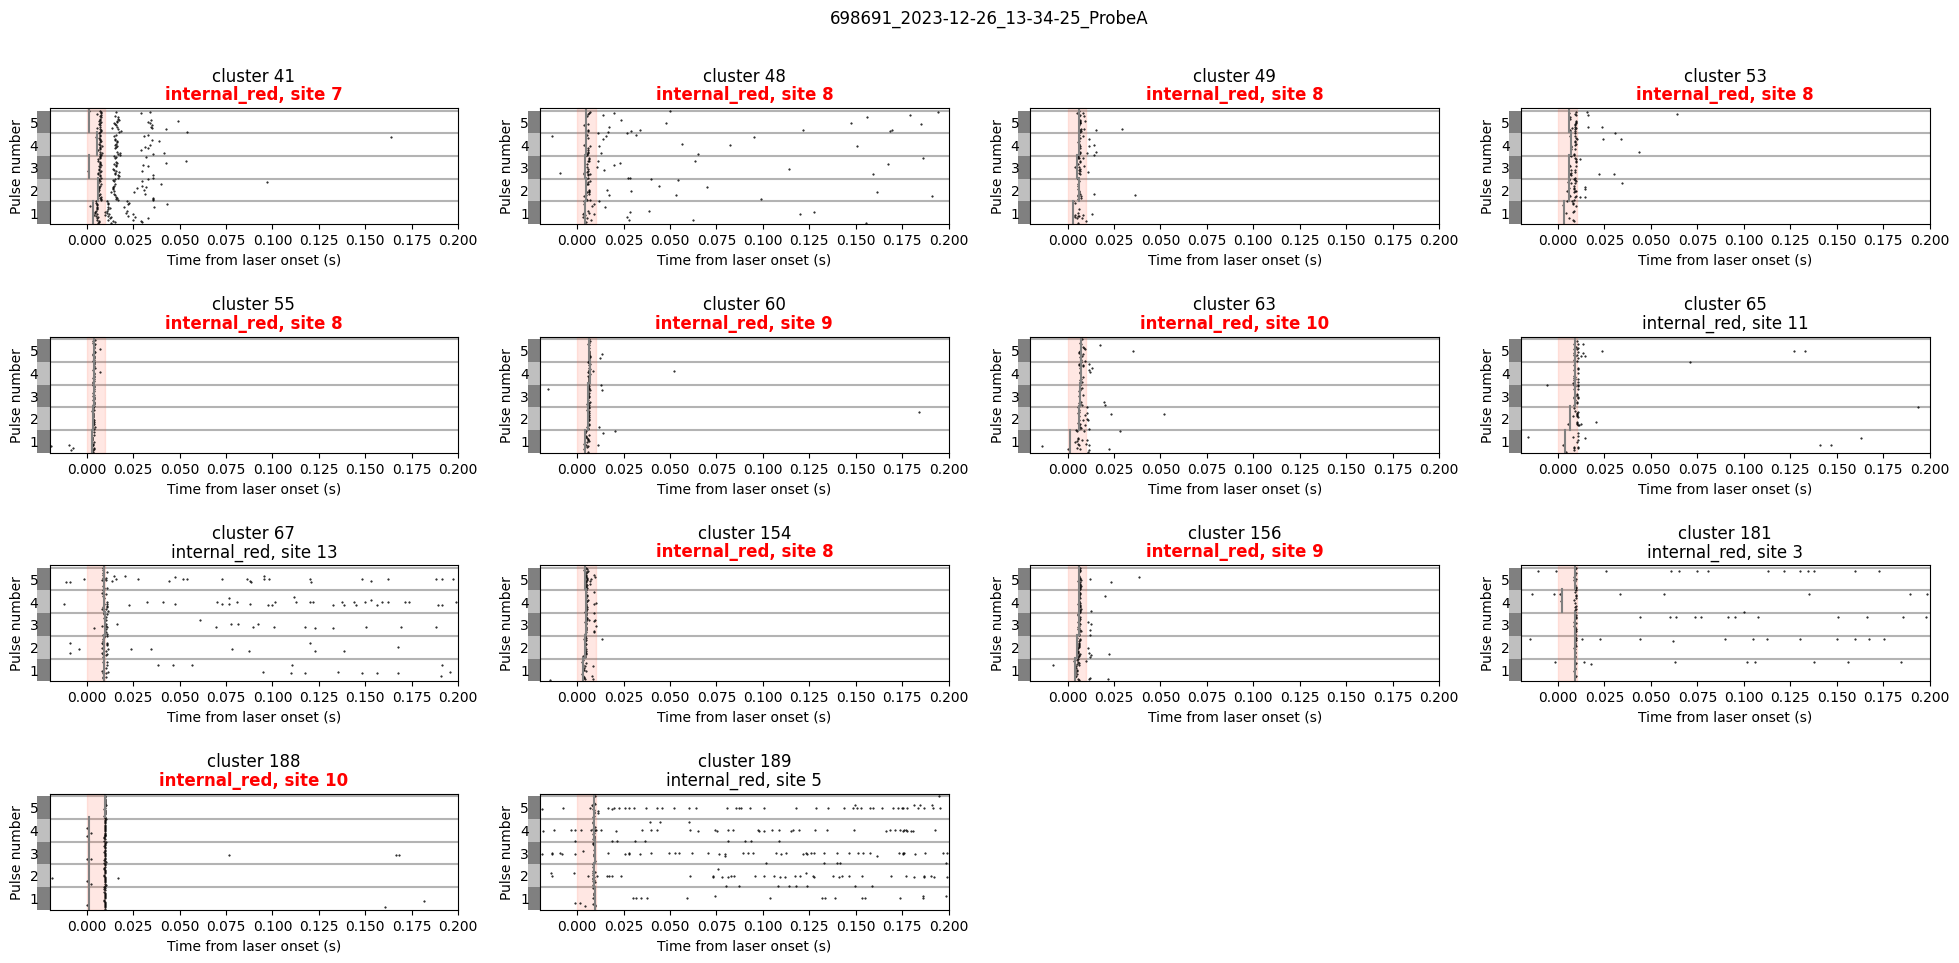

In [7]:
# plot_units.plot_all_good_units(responsive_units, sorting_responsive, timestamps, laser_onset_times, event_ids, we, session, probe, max_channel, param_group, fig_name=f'{session}_{probe}_all_laser_responsive.{fig_format}', old_tag=OLD)
plot_units.plot_laser_responsive_units(responsive_units, sorting_responsive, timestamps, laser_onset_times, event_ids, session, probe, param_group, fig_name=f'{session}_{probe}_laser_responses_detail.{fig_format}', old_tag=OLD)


### Unit plot

In [213]:
#responsive_ids:  [41, 48, 49, 53, 55, 60, 63, 65, 67, 154, 156, 181, 188, 189]
units_to_plot = [63]
ROI_units = laser_response_metrics.query('unit_id == @units_to_plot')
ROI_ids = ROI_units.unit_id.tolist()
sorting_ROI = sorting_output.select_units(ROI_ids)

we = si.WaveformExtractor.load_from_folder(waveform_folder, with_recording=False, sorting=sorting_output)

# for ind_unit, unit in enumerate(ROI_units.unit_id):    
#     print(f'Unit {unit}')
#     plot_units.plot_ROI_unit(ROI_units, sorting_responsive, timestamps, laser_onset_times, event_ids, we, session, probe, max_channel, param_group, fig_name=f'{session}_{probe}_all_laser_responsive.{fig_format}', old_tag=OLD)

#Col:  1 #Row:  1
Plotting 1 units
Unit 0
['internal_red']
Added title
Plotted rasters
Plotted waveforms
d:\Ephys\OptoTaggingAnalysis\code


d:\Ephys\OptoTaggingAnalysis\code\plotting_funcs.py:44: UserWarning: Overwriting the cmap 'shifted_PRGn' that was already in the registry.
  matplotlib.colormaps.register(cmap=newcmap, force=True)


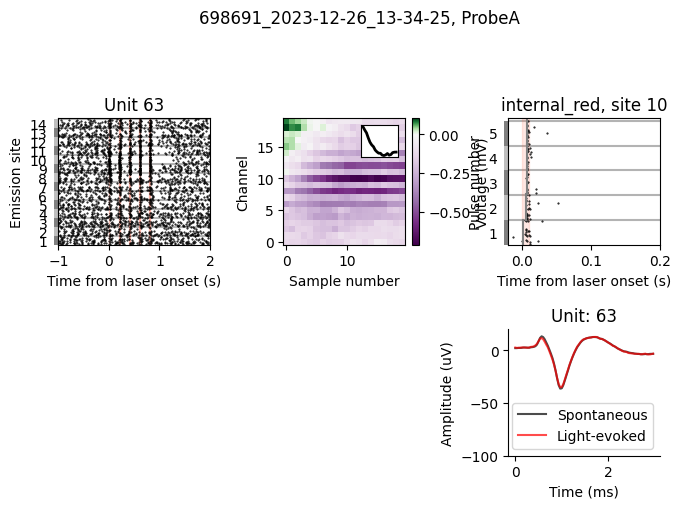

In [228]:
units_to_plot = ROI_units 
old_tag=OLD
num_cols = int(np.ceil(np.sqrt(len(units_to_plot))))
num_rows = int(np.ceil(len(units_to_plot) / num_cols))
print('#Col: ', num_cols, '#Row: ', num_rows)

# Trial types present
trial_types = np.unique(event_ids.type)
internal_trials = [trial_type for trial_type in trial_types if 'internal' in trial_type]

plt.clf()
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(top=0.93, bottom=0.05, left=0.03, right=0.97, wspace=0.03, hspace=1)
fig_name = 'Test.png'

# format the gridspec based on trial types present
if ('external_blue' or 'external_red') in trial_types:
    height_ratios=[0.01,0.3,1]
    hspace = 0.8
    panel_height = 5
else:
    height_ratios=[0.005,1]
    hspace = 0.5
    panel_height = 3

#width_ratios=np.ones(len(np.unique(event_ids['wavelength']))+1).tolist()
hspace = 1
height_ratios= [0.005,1,1]
width_ratios = [1,0.1,1,0.1,1] # fix this later

print(f'Plotting {len(units_to_plot.unit_id)} units')
for ind_unit, unit in enumerate(units_to_plot.unit_id):
    sample_numbers = sorting_output.get_unit_spike_train(unit)
    unit_spike_times = timestamps[sample_numbers]

    unit_waveform = we.get_template(unit)
    print(f'Unit {ind_unit}')
    trial_types = np.unique(event_ids.type)
    print(trial_types)        
    gs_this_unit = gridspec.GridSpecFromSubplotSpec(3, 5, subplot_spec=gs[ind_unit//num_cols, np.mod(ind_unit, num_cols)], wspace=0.3, hspace=hspace, height_ratios=height_ratios, width_ratios=width_ratios)

    # Add ghost axes so I can add a title with cluster number...
    ax_title = plt.subplot(gs_this_unit[0, :])
    ax_title.axis('off')
    print('Added title')

    for ind_type, trial_type in enumerate(trial_types):
        if 'internal' in trial_type:
            # plot npopto stim by site
            max_power = max(event_ids.query('type == @trial_type').power)
            sites = list(np.unique(event_ids.query('type == @trial_type').site))
            if old_tag:
                tag_trials = event_ids.query('param_group == @param_group and site == @sites and power == @max_power and type == @trial_type')
            else:
                tag_trials = event_ids.query('param_group == @param_group and site == @sites and power == @max_power and type == @trial_type and emission_location == @probe')
            y_axis = tag_trials.site.tolist()
            y_label = 'Emission site'
            y_ticks = sites
            x_label = 'Time from laser onset (s)'

        elif 'external' in trial_type:
            # plot surface stim by power
            site = list(np.unique(event_ids.query('type == @trial_type').site))
            powers = list(np.unique(event_ids.query('type == @trial_type').power))
            tag_trials = event_ids.query('param_group == @param_group and site == @site and power == @powers and type == @trial_type')
            y_axis = tag_trials.power.tolist()
            y_label = 'Laser power (mW)'
            y_ticks = powers
            x_label = None        

    duration = np.unique(tag_trials.duration)[0]
    num_pulses = np.unique(tag_trials.num_pulses)[0]
    pulse_interval = np.unique(tag_trials.pulse_interval)[0]
    total_duration = (duration*num_pulses)+(pulse_interval*num_pulses)
    raster_time_range = [-total_duration/1000, (2*total_duration)/1000]
    wavelength = np.unique(tag_trials.wavelength)[0]

    # plot raster
    # ax_raster = plt.subplot(gs_this_unit[1 + ind_type//2, ind_type%2])
    ax_raster = plt.subplot(gs_this_unit[1:3, 0])
    this_event_timestamps = laser_onset_times[tag_trials.index.tolist()]
    event_locked_timestamps = af.event_locked_timestamps(unit_spike_times, this_event_timestamps, raster_time_range)
    pf.raster_plot(event_locked_timestamps, raster_time_range, y_axis, ms=100, markeredgecolor='none')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim(raster_time_range)
    ax_raster.set_yticklabels(y_ticks)
    this_unit_id = units_to_plot.unit_id.tolist()[ind_unit]
    plt.title(f'Unit {this_unit_id}')
    
    # this_type_laser_param = f'{trial_type}_{param_group}_num_sig_pulses_paired'
    # weight = 'extra bold' if units_to_plot[this_type_laser_param].iloc[ind_unit] == 5 else 'normal'
    # title_color = 'red' if units_to_plot[this_type_laser_param].iloc[ind_unit] == 5 else 'black'
    # plt.title(f'{trial_type}', fontweight = weight, color = title_color)
    # plt.title(f'{trial_type}, {wavelength} nm')

    # patches showing laser presentation
    yLims = np.array(plt.ylim())
    laser_color = 'tomato' # if 'red' in trial_type else 'skyblue'
    for pulse in range(num_pulses):
        rect = patches.Rectangle((pulse * (duration+pulse_interval)/1000, yLims[0]), duration / 1000, yLims[1] - yLims[0], linewidth=1, edgecolor=laser_color, facecolor=laser_color, alpha=0.35, clip_on=False)
        ax_raster.add_patch(rect)
    print('Plotted rasters')

    # plot waveform
    ax_waveform = plt.subplot(gs_this_unit[1:3,2])
    cmap = matplotlib.cm.PRGn
    #cmap = matplotlib.cm.viridis
    shifted_cmap = pf.shiftedColorMap(cmap, np.min(unit_waveform[70:170,:]), np.max(unit_waveform[70:170,:]), 'shifted_PRGn')
    waveform_peak = np.min(unit_waveform)
    plt.imshow(0.195*unit_waveform[70:170,:max_channel].T, aspect='auto', cmap=shifted_cmap)
    ax_waveform.invert_yaxis()
    plt.ylabel('Channel')
    plt.xlabel('Sample number')
    cbar = plt.colorbar()
    cbar.set_label('Voltage (mV)')

    # inset with peak channel waveform
    peak_ind = np.where(unit_waveform==waveform_peak)
    peak_waveform = unit_waveform[70:150,peak_ind[1][0]]
    #peak_channel = int(units_to_plot.iloc[ind_unit]['peak_channel']) - 1
    #print('Peak Ch: ', peak_channel)
    #peak_waveform = unit_waveform[70:170,peak_channel]

    ax_inset = inset_axes(ax_waveform, width="30%", height="25%", loc=1, bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax_waveform.transAxes)
    plt.plot(peak_waveform, lw=2, c='k')
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    print('Plotted waveforms')
    
    # plot raster of laser response for each pulse and each laser colour
    for ind_type, trial_type in enumerate(internal_trials):
        max_power = max(event_ids.query('type == @trial_type').power)
        best_site = units_to_plot[f'{trial_type}_{param_group}_best_site'].iloc[ind_unit]
        tag_trials = event_ids.query('param_group == @param_group and site == @best_site and power == @max_power and type == @trial_type')
        duration = np.unique(tag_trials.duration)[0]
        num_pulses = np.unique(tag_trials.num_pulses)[0]
        pulse_interval = np.unique(tag_trials.pulse_interval)[0]
        total_duration = (duration*num_pulses)+(pulse_interval*num_pulses)
        time_range_raster = [-(duration * 2) / 1000, (duration + pulse_interval) / 1000]
        
        int_event_locked_timestamps = []
        pulse_nums = []
        this_event_timestamps = laser_onset_times[tag_trials.index.tolist()]

        for pulse_num in range(num_pulses):
            time_shift = pulse_num*(duration+pulse_interval)/1000
            this_time_range = [time_range_raster[0]+time_shift, time_range_raster[1]+time_shift]
            this_event_locked_timestamps = af.event_locked_timestamps(unit_spike_times, this_event_timestamps, this_time_range, time_shift=time_shift)
            int_event_locked_timestamps.extend(this_event_locked_timestamps)
            pulse_nums.extend([pulse_num+1]*len(this_event_locked_timestamps))

        ax_raster = plt.subplot(gs_this_unit[1, 4])
        # ax_raster = plt.subplot(gs_this_unit[1, ind_type])
        pf.raster_plot(int_event_locked_timestamps, time_range_raster, cond_each_trial=pulse_nums, ms=100)
        plt.xlabel('Time from laser onset (s)')
        if ind_type==0:
            plt.ylabel('Pulse number')
        plt.xlim(time_range_raster)

        # show latency for each pulse
        this_type_latency_param = f'{trial_type}_{param_group}_all_latencies'
        all_latencies = units_to_plot[this_type_latency_param].iloc[ind_unit]
        # pulling some janky shit to read a list stored in the dataframe...
        all_latencies = all_latencies.replace('nan', 'None')
        all_latencies = ast.literal_eval(all_latencies)
        figure_cond_fraction = 1/num_pulses
        for pulse_num in range(num_pulses):
            this_pulse_latency = all_latencies[pulse_num]
            if this_pulse_latency is not None:
                plt.axvline(this_pulse_latency, ymin=pulse_num*figure_cond_fraction, ymax=(pulse_num+1)*figure_cond_fraction, color='gray')

        # patches showing laser presentation
        yLims = np.array(plt.ylim())
        laser_color = 'skyblue' if 'blue' in trial_type else 'tomato'
        rect = patches.Rectangle((0, yLims[0]), duration / 1000, yLims[1] - yLims[0], linewidth=1, edgecolor=laser_color,
                                    facecolor=laser_color, alpha=0.15, clip_on=False)
        ax_raster.add_patch(rect)

        this_type_laser_param = f'{trial_type}_{param_group}_num_sig_pulses_paired'
        this_type_latency_param = f'{trial_type}_{param_group}_mean_latency'
        #tagged_unit = units_to_plot[this_type_laser_param].iloc[ind_unit] == 5
        tagged_unit = (units_to_plot[this_type_laser_param].iloc[ind_unit] == 5 and units_to_plot[this_type_latency_param].iloc[ind_unit] < 0.007)
        # weight = 'extra bold' if tagged_unit else 'normal'
        title_color = 'red' if tagged_unit else 'black'
        plt.title(f'{trial_type}, site {best_site:1.0f}', color = 'k')

        # plot mean waveform spont and light evoked
        ax_wfvs = plt.subplot(gs_this_unit[2,4])
        plt.plot(x,meanWFs[1, :, peak_channel, 0],'k',alpha=0.7,label='Spontaneous')
        plt.plot(x,meanWFs[2, :, peak_channel, 0],'r',alpha=0.7,label='Light-evoked')
        plt.legend(loc="lower right")
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (uV)')
        plt.title(f'Unit: {unit}')
        plt.ylim([-100, 20])
        # plt.title(f'Unit: {unit}, Peak Ch: {peak_channel}')
        ax_wfvs.spines[['right', 'top']].set_visible(False)
        plt.show


# plt.gcf().set_size_inches((11 * num_cols, panel_height * num_rows))
# Super title
plt.suptitle(f'{session}, {probe}')

if fig_name is None:
    fig_name = f'{session}_{probe}_all_good_units.{fig_format}'
print(os.getcwd())

## Waveform

In [229]:
stream_name = "experiment1_Record Node 104#Neuropix-PXI-100.ProbeA-AP_recording1"

precurated_sorted_folder = f"{sorting_folder}/sorting_precurated/{stream_name}"
precurated_sorting = si.load_extractor(precurated_sorted_folder)


In [230]:
def extractSpikes(timestamps, alignTimes, window):
    selectedInds = []
    selectedTimeStamps = []
    
    for intTime, currTime in enumerate(alignTimes):
#         time_range_this_trial = np.array([currTime, currTime + window])
#         spike_inds_this_trial = np.searchsorted(timestamps, time_range_this_trial)
#         spike_times_this_trial = spike_timestamps[spike_inds_this_trial[0]:spike_inds_this_trial[1]]
        currInds = np.where((timestamps > currTime) & (timestamps < currTime + window))[0]
        currTimeStamps = timestamps[currInds] - currTime
        selectedInds = np.concatenate((selectedInds, currInds))
        selectedTimeStamps = np.concatenate((selectedTimeStamps, currTimeStamps))
    
    selectedInds = selectedInds.astype(int)
    return selectedInds, selectedTimeStamps

In [231]:
# we load the pre-computed waveforms to access the sparsity
allWF_folder = "../results/we_all"
we = si.load_waveforms(allWF_folder, with_recording=False)
print('All waveforms loaded.')

All waveforms loaded.


In [232]:
# Individual unit
wf_window = 20/1000 # 20 ms
unit = ROI_units.unit_id.tolist()[0]
print(unit)

# Get waveforms for the unit
waveforms = we.get_waveforms(unit) # The waveforms shape is (num_spikes, num_sample, num_channel)
print('Wf shape: ', waveforms.shape)
# Calculate the shape of the waveforms
wfShape = np.shape(waveforms)

# Initialize mean waveforms array
meanWFs = np.zeros([3+len(sites), wfShape[1], wfShape[2], len(powers)]) # (3+len(sites), num_sample, num_channel, num_power)

# Get sample numbers and corresponding spike timestamps
sample_numbers = precurated_sorting.get_unit_spike_train(unit)
currSpikes = timestamps[sample_numbers]

# Print information about the current unit
print(f"On unit {unit}. Total spike number {len(currSpikes)}")

# Initialize a list to store indices of laser waveforms
allLaserWFInd = []
for indPower, currPower in enumerate(powers):
    for indSite, currSite in enumerate(sites):
        # Query events based on site and power
        current_events = event_ids.query('site == @currSite and power == @currPower')
        current_events = current_events.index.tolist()
        currTSs = laser_onset_times[current_events]
        wfInd = []
        for currPulse in range(num_pulses):
            currAlignTimes = currTSs + currPulse*pulse_offset
            selectedInds, selectedTimeStamps = extractSpikes(currSpikes, currAlignTimes, wf_window)
#                 print(f"spike number {len(selectedInds)}")
            wfInd = np.concatenate((wfInd, selectedInds))              
        
        wfInd = wfInd.astype(int)
        currMeanWF = np.mean(waveforms[wfInd, :, :], axis = 0);
        meanWFs[3+indSite, :, :, indPower] = currMeanWF
        allLaserWFInd = np.concatenate((allLaserWFInd, wfInd))
            
    allInds = np.array(range(len(sample_numbers)))
    allLaserWFInd = allLaserWFInd.astype(int)

    # Calculate spontaneous waveforms
    spontInds = ~np.in1d(allInds, allLaserWFInd)
    afterLaserInds = currSpikes > laser_onset_times[0]
    spontWF = np.mean(waveforms[spontInds, :, :], axis = 0)
    # Calculate light-evoked waveforms    
    leWF = np.mean(waveforms[afterLaserInds, :, :], axis = 0);

    meanWFs[0, :, :, 0] = np.mean(waveforms, axis = 0) # All waveforms
    meanWFs[1, :, :, 0] = spontWF # spontWF
    meanWFs[2, :, :, 0] = leWF # leWF

    # # Correlation between spontaneous and light-evoked spike WFs
    # # Calculate cross-correlation
    # cross_correlation = correlate(meanWFs[1, :, :, 0], meanWFs[2, :, :, 0], mode='full')
    
    # # Calculate similarity score as the maximum of the cross-correlation
    # similarity_score = max(cross_correlation)
    # print(similarity_score)

    # light-evoked first-spike latency

    # first-spike jitter 

63
Wf shape:  (6040, 90, 20)
On unit 63. Total spike number 6040


In [233]:
# peak channel waveform
peak_ind = np.where(unit_waveform==waveform_peak)
peak_waveform = unit_waveform[70:150,peak_ind[1][0]]
peak_channel = peak_ind[1][0]
print('Peak Ch: ', peak_channel)
peak_waveform = unit_waveform[70:170,peak_channel]
        
df = np.mean(np.diff(timestamps))*1000
print(df)
x = df*np.arange(len(meanWFs[0, :, peak_channel, 0]))

Peak Ch:  10
0.03333643475034794


<function matplotlib.pyplot.show(close=None, block=None)>

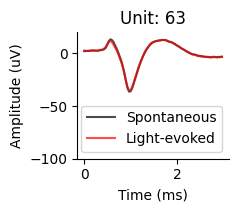

In [234]:
ax_wfvs = plt.subplot(gs_this_unit[2,2])
plt.plot(x,meanWFs[1, :, peak_channel, 0],'k',alpha=0.7,label='Spontaneous')
plt.plot(x,meanWFs[2, :, peak_channel, 0],'r',alpha=0.7,label='Light-evoked')
plt.legend(loc="lower right")
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.title(f'Unit: {unit}')
plt.ylim([-100, 20])
# plt.title(f'Unit: {unit}, Peak Ch: {peak_channel}')
ax_wfvs.spines[['right', 'top']].set_visible(False)
plt.show
